In the name of god

ANN Project - Fruit Classification

Niki Pourazin


# Implementing Feed Forward

First of all, we retreive the train set by using the previously implemented methods in Loading_Datasets.py.

In [11]:
import numpy as np
import random
import matplotlib.pyplot as plt
from ANN_Project_Assets import Loading_Datasets as ld

train_set = ld.load_and_get_set(test_or_train="train",
                                feature_file_path="ANN_Project_Assets/Datasets/train_set_features.pkl",
                                label_file_path="ANN_Project_Assets/Datasets/train_set_labels.pkl")

layer_sizes = [len(train_set[0][0]), 150, 60, 4]  # [102, 150, 60, 4]

The loaded set's size:  1962


Then, we declare the weight and bias variable; The weight and bias for between layers k and k+1 are notated by W[k] and B[k].

In [2]:
# There are 4 layers, between each two consecutive layers, there needs to be a weight matrix
W = [
    np.random.normal(size=(layer_sizes[1], layer_sizes[0])),  # weights between layer 0 and 1, aka W[0]
    np.random.normal(size=(layer_sizes[2], layer_sizes[1])),  # weights between layer 1 and 2, aka W[1]
    np.random.normal(size=(layer_sizes[3], layer_sizes[2]))  # weights between layer 2 and 3, aka W[2]
]

# Initialize bias to 0, for every layer.
B = [
    np.zeros((layer_sizes[1], 1)),  # bias vector between layer 0 and 1, aka B[0]
    np.zeros((layer_sizes[2], 1)),  # bias vector between layer 1 and 2, aka B[1]
    np.zeros((layer_sizes[3], 1)),  # bias vector between layer 2 and 3, aka B[2]
]

We would need two methods to use in the feed forwrd implementation.
one is the activation function, here we implement the sigmoid function and use it later as the acivation function.
the other is used for checking the labels, used to compare the calculated and actual values of the labels.

In [3]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def check_accuracy(calculated_labels, correct_labels):
    calculated_ans = np.where(calculated_labels == np.amax(calculated_labels))
    correct_ans = np.where(correct_labels == np.amax(correct_labels))

    return calculated_ans == correct_ans

aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa

In [5]:
def run_feed_forward():
    data_size = 200  # number of train set elements taken from the train set
    correct_ans_count = 0  # number of correct answers, initialized at 0

    for td in train_set[:data_size]:
        z = [
            np.zeros((layer_sizes[0], 1)),
            np.zeros((layer_sizes[1], 1)),
            np.zeros((layer_sizes[2], 1)),
            np.zeros((layer_sizes[3], 1))

        ]

        # values of the first layer (0th), initialized as the train data
        z[0] = td[0]
        np.reshape(z[0], (102, 1))

        for i in range(1, 4):
            # for each next layer, z is calculated as discussed below
            z[i] = sigmoid(W[i - 1] @ z[i - 1] + B[i - 1])

        if check_accuracy(z[3], td[1]):
            correct_ans_count += 1

    return correct_ans_count / data_size


print("Feed Forward Accuracy: ", run_feed_forward())

Feed Forward Accuracy:  0.235


As expected, accuracy is very low and around 0.25 (as in a ranodom choice of 1 in 4)
In the feed forward network, implemented above, the system has no ability in "learning". In the next step, we make it so the NN can adjust the weights for better and better results. 

# Back Propagation

Back Propagation Accuracy:  1.0
Wall time: 1min 13s


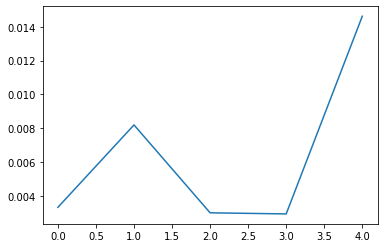

In [19]:
%%time

def d_sigmoid(x):
    return sigmoid(x) * (1 - sigmoid(x))


# Hyper parameters
batch_size = 10
learning_rate = 1
epoch_number = 5
costs = []

def run_back_propagated():
    data_size = 200
    trimmed_train_set = train_set[:data_size]

    for i in range(0, epoch_number):
        # shuffle the train set
        random.shuffle(trimmed_train_set)
        batches = [train_set[x:x + batch_size] for x in range(0, 100, batch_size)]
        for batch in batches:

            grad_W = [
                np.random.normal(size=(layer_sizes[1], layer_sizes[0])),
                np.random.normal(size=(layer_sizes[2], layer_sizes[1])),
                np.random.normal(size=(layer_sizes[3], layer_sizes[2]))
            ]

            grad_B = [
                np.zeros((layer_sizes[1], 1)),
                np.zeros((layer_sizes[2], 1)),
                np.zeros((layer_sizes[3], 1))
            ]
            for td in batch:
                z = [
                    np.zeros((layer_sizes[0], 1)),
                    np.zeros((layer_sizes[1], 1)),
                    np.zeros((layer_sizes[2], 1)),
                    np.zeros((layer_sizes[3], 1))
                ]

                # values of the first layer (0th), initialized as the train data
                z[0] = td[0]
                np.reshape(z[0], (102, 1))

                for i in range(1, 4):
                    # for each next layer, z is calculated as discussed below
                    z[i] = sigmoid(W[i - 1] @ z[i - 1] + B[i - 1])

                    # ** layer 4
                for j in range(layer_sizes[3]):
                    grad_B[2][j, 0] += 2 * (z[3][j, 0] - td[1][j, 0]) * d_sigmoid(z[3][j, 0])  # bias layer 4

                    for k in range(layer_sizes[2]):  # weight layer 4
                        grad_W[2][j, k] += 2 * (z[3][j, 0] - td[1][j, 0]) * d_sigmoid(z[3][j, 0]) * z[2][k, 0]

                delta_2 = np.zeros((layer_sizes[2], 1))
                for k in range(layer_sizes[2]):
                    for j in range(layer_sizes[3]):
                        delta_2[k, 0] += 2 * (z[3][j, 0] - td[1][j, 0]) * d_sigmoid(z[3][j, 0]) * W[2][j, k]

                # ** layer 3
                for j in range(layer_sizes[2]):
                    grad_B[1][j, 0] += delta_2[j, 0] * d_sigmoid(z[2][j, 0])  # bias layer 3

                    for k in range(layer_sizes[1]):  # weight layer 3
                        grad_W[1][j, k] += delta_2[j, 0] * d_sigmoid(z[2][j, 0]) * z[1][k, 0]

                delta_1 = np.zeros((layer_sizes[1], 1))
                for k in range(layer_sizes[1]):
                    for j in range(layer_sizes[2]):
                        delta_1[k, 0] += delta_2[j, 0] * d_sigmoid(z[2][j, 0]) * W[1][j, k]

                # ** layer 2
                for j in range(layer_sizes[1]):
                    grad_B[0][j, 0] += delta_1[j, 0] * d_sigmoid(z[1][j, 0])  # bias layer 2

                    for k in range(layer_sizes[0]):  # weight layer 2
                        grad_W[0][j, k] += delta_1[j, 0] * d_sigmoid(z[1][j, 0]) * z[0][k, 0]

            # update, using the gradient
            for ind in range(0, 3):
                W[ind] -= learning_rate * (grad_W[ind] / batch_size)
                B[ind] -= learning_rate * (grad_B[ind] / batch_size)

        cost = 0
        for td in trimmed_train_set:
            z = [
                np.zeros((layer_sizes[0], 1)),
                np.zeros((layer_sizes[1], 1)),
                np.zeros((layer_sizes[2], 1)),
                np.zeros((layer_sizes[3], 1))
            ]
            # values of the first layer (0th), initialized as the train data
            z[0] = td[0]
            np.reshape(z[0], (102, 1))

            for it in range(1, 4):
                # for each next layer, z is calculated as discussed below
                z[it] = sigmoid(W[it - 1] @ z[it - 1] + B[it - 1])

            for j in range(layer_sizes[3]):
                cost += np.power((z[3][j, 0] - td[1][j, 0]), 2)

        cost /= 100
        costs.append(cost)
        
run_back_propagated()

epoch_size = [x for x in range(epoch_number)]
plt.plot(epoch_size, costs)
print("Back Propagation Accuracy: ", run_feed_forward())


In [ ]:
%%time
batch_size = 20
learning_rate = 1
epoch_number = 5

run_back_propagated()

epoch_size = [x for x in range(epoch_number)]
plt.plot(costs)
print("Back Propagation Accuracy: ", run_feed_forward())
